In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

IMAGE_SIZE = 224
BATCH_SIZE = 5

Criando um gerador de dados que irá redimensionar as imagens e usa 20% dos dados para validação.

In [3]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  validation_split=0.2)

Criando gerador para dados de treinamento

In [4]:
train_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  subset='training')

Found 1440 images belonging to 17 classes.


E gerador para validação

In [5]:
val_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  subset='validation')

Found 360 images belonging to 17 classes.


Triggering `train_generator` para cada batch

In [6]:
for image_batch, label_batch in train_generator:
  break

Mostrando os labels de classificação

In [7]:
print(train_generator.class_indices)

{'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}


Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

Criando uma model com base na CNN pré treinada MobileNet V2, desenvolvida pela Google e pré-treinada usando o dataset da ImageNet, sem a camada superior, que inclui as camadas de classificação.

In [9]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=1000,
    **kwargs
)


2023-07-16 11:31:51.307965: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-16 11:31:51.307996: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-16 11:31:51.308007: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-16 11:31:51.308085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 11:31:51.308287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Aplicando fine-tunning nas últimas camadas do modelo, forçando os pesos a se ajustarem äs características mais específicas do dataset.

In [10]:
base_model.trainable = True

Mostrando a quantidade de camadas no modelo.

In [11]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Definindo a camada a partir da qual será aplicado o fine-tuning.

In [12]:
fine_tune_at = 100

Congelando as camadas antes da camada definida em `fine_tune_at`

In [13]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### APAGAR

Feature extraction<br>
You will freeze the convolution base created from the previous step and use that as a feature extractor<br>
Add a classifier on top of it and train the top-level classifier.

We will be tweaking the model with our own classifications<br>
Hence we don't want our tweaks to affect the layers in the 'base_model'<br>
Hence we disable their training

In [14]:
# base_model.trainable = False

Montando o modelo da CNN:
1. Modelo pré-treinado da MobileNet V2 com fine-tunning a partir da 100a camada;
2. Camada de Convolução com 32 filtros e ativação Relu;
3. Camada de Dropout de 20% dos nós;
4. Camada de Pooling;
5. Camada FC com 17 labels de classificação

In [15]:
model = tf.keras.Sequential([
    base_model,  # 1
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2
    tf.keras.layers.Dropout(0.2),  # 3
    tf.keras.layers.GlobalAveragePooling2D(),  # 4
    tf.keras.layers.Dense(17, activation='softmax')  # 5
])

Compilando a model

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3
# To see the model summary in a tabular structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 17)                561       
                                                                 
Total params: 2627217 (10.02 MB)
Trainable params: 22306

Definindo as épocas para o treinamento da model

In [17]:
epochs = 20

Treinando a model

In [18]:
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/20


2023-07-16 11:31:53.590493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


287/288 [============================>.] - ETA: 0s - loss: 2.6759 - accuracy: 0.1303

2023-07-16 11:32:06.550624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 16s 48ms/step - loss: 2.6758 - accuracy: 0.1299 - val_loss: 3.2877 - val_accuracy: 0.1333
Epoch 2/20
288/288 [==============================] - 12s 43ms/step - loss: 2.2197 - accuracy: 0.2264 - val_loss: 7.0575 - val_accuracy: 0.0861
Epoch 3/20
288/288 [==============================] - 13s 44ms/step - loss: 1.9057 - accuracy: 0.3000 - val_loss: 5.2117 - val_accuracy: 0.1194
Epoch 4/20
288/288 [==============================] - 12s 43ms/step - loss: 1.6951 - accuracy: 0.3646 - val_loss: 4.5596 - val_accuracy: 0.1528
Epoch 5/20
288/288 [==============================] - 13s 43ms/step - loss: 1.4554 - accuracy: 0.4563 - val_loss: 8.5427 - val_accuracy: 0.1250
Epoch 6/20
288/288 [==============================] - 13s 44ms/step - loss: 1.2352 - accuracy: 0.5347 - val_loss: 14.1602 - val_accuracy: 0.1222
Epoch 7/20
288/288 [==============================] - 13s 43ms/step - loss: 1.1267 - accuracy: 0.5847 - val_loss: 2.2544 - val_accuracy: 0.2861
Ep

Visualizando as curvas de aprendizado

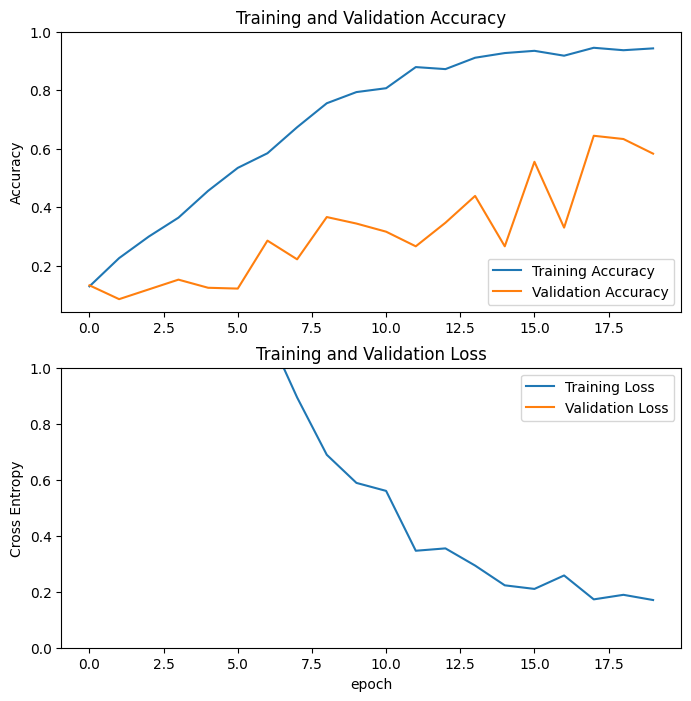

In [19]:
acc       = history.history['accuracy']
val_acc   = history.history['val_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

Tentando predizer uma imagem fora do dataset de treinamento

In [26]:
import tensorflow as tf
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
# from keras.models import load_model

In [61]:
img_path = 'test/angelina.jpg'
img = image.load_img(img_path, target_size=(224, 224))

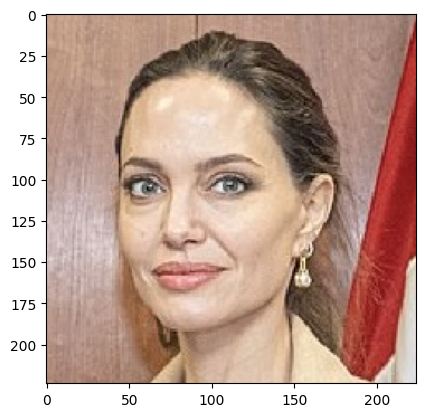

In [62]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [63]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [64]:
prediction = model.predict(img_preprocessed)

1/1 [==============================] - 0s 30ms/step


Mostrando Predição

In [68]:
labels = sorted(train_generator.class_indices.keys())

idx_label = prediction.argmax()
print('Predição:', labels[idx_label])

Predição: Angelina Jolie
